The aim of the project is to correctly identify the weed type from a variety of weed and crop RGB images.

Data in this [link](https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset)

Preprocessing:
- Need to change rename directory "Sheperd's Purse" to "Sheperds Purse" to avoid parsing issues.
- We will need to rescale the figures all to the same size.

In [1]:
# to handle datasets
import numpy as np
import pandas as pd

# to navigate folders
import os
from glob import glob

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# to open the images
import cv2

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [3]:
# data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# evaluate model and separate train and test
from sklearn.metrics import confusion_matrix

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import image
from keras.utils import np_utils

# 3 Load Images / Data

In [6]:
# here are all our images
DATA_FOLDER = '/home/roberto/Documents/deployment_of_ML_presentations/v2-plant-seedlings-dataset'

In [7]:
# each weed class is in a dedicated folder
os.listdir(DATA_FOLDER)

['Charlock',
 'Black-grass',
 'Cleavers',
 'Common wheat',
 'Small-flowered Cranesbill',
 'Common Chickweed',
 'Sugar beet',
 'Scentless Mayweed',
 'nonsegmentedv2',
 'Loose Silky-bent',
 'Maize',
 'Shepherds Purse',
 'Fat Hen']

In [9]:
# Let's walk over the directory structure, so we understand
# how the images are stored

for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        print(image_path)

/home/roberto/Documents/deployment_of_ML_presentations/v2-plant-seedlings-dataset/Charlock/356.png
/home/roberto/Documents/deployment_of_ML_presentations/v2-plant-seedlings-dataset/Charlock/258.png
/home/roberto/Documents/deployment_of_ML_presentations/v2-plant-seedlings-dataset/Charlock/239.png
/home/roberto/Documents/deployment_of_ML_presentations/v2-plant-seedlings-dataset/Charlock/365.png
/home/roberto/Documents/deployment_of_ML_presentations/v2-plant-seedlings-dataset/Charlock/19.png
/home/roberto/Documents/deployment_of_ML_presentations/v2-plant-seedlings-dataset/Charlock/363.png
/home/roberto/Documents/deployment_of_ML_presentations/v2-plant-seedlings-dataset/Charlock/285.png
/home/roberto/Documents/deployment_of_ML_presentations/v2-plant-seedlings-dataset/Charlock/89.png
/home/roberto/Documents/deployment_of_ML_presentations/v2-plant-seedlings-dataset/Charlock/161.png
/home/roberto/Documents/deployment_of_ML_presentations/v2-plant-seedlings-dataset/Charlock/65.png
/home/roberto

In [11]:
# Let's create a dataframe:
# the dataframe stores the path to the image in one column
# and the class of the weed (the target) in the next column

images_df = []

# navigate within each folder
for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)

    # collect every image path
    for image_path in glob(os.path.join(class_folder_path, "*.png")):

        tmp = pd.DataFrame([image_path, class_folder_name]).T
        images_df.append(tmp)

# concatenate the final df
images_df = pd.concat(images_df, axis=0, ignore_index=True)
images_df.columns = ['image', 'target']
images_df.head(10)


,image,target
0,/home/roberto/Documents/deployment_of_ML_prese...,Charlock
1,/home/roberto/Documents/deployment_of_ML_prese...,Charlock
2,/home/roberto/Documents/deployment_of_ML_prese...,Charlock
3,/home/roberto/Documents/deployment_of_ML_prese...,Charlock
4,/home/roberto/Documents/deployment_of_ML_prese...,Charlock
5,/home/roberto/Documents/deployment_of_ML_prese...,Charlock
6,/home/roberto/Documents/deployment_of_ML_prese...,Charlock
7,/home/roberto/Documents/deployment_of_ML_prese...,Charlock
8,/home/roberto/Documents/deployment_of_ML_prese...,Charlock
9,/home/roberto/Documents/deployment_of_ML_prese...,Charlock


In [12]:
# how many images do we've got per class?
# this should give similar results to what we observed
# when we inspected the length of image list in the dictionary

images_df['target'].value_counts()

target
Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherds Purse              274
Maize                        257
Common wheat                 253
Name: count, dtype: int64

In [13]:
# let's isolate a path, for demo
# we want to load the image in this path later

images_df.loc[0, 'image']

'/home/roberto/Documents/deployment_of_ML_presentations/v2-plant-seedlings-dataset/Charlock/356.png'

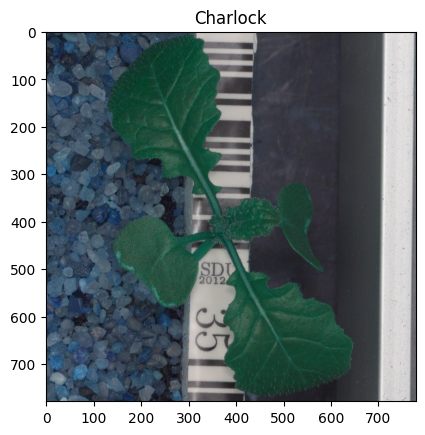

In [14]:
# let's visualize a few images

def plot_single_image(df, image_number):
    im = cv2.imread(df.loc[image_number, 'image'])
    plt.title(df.loc[image_number, 'target'])
    plt.imshow(im)

plot_single_image(images_df, 0)

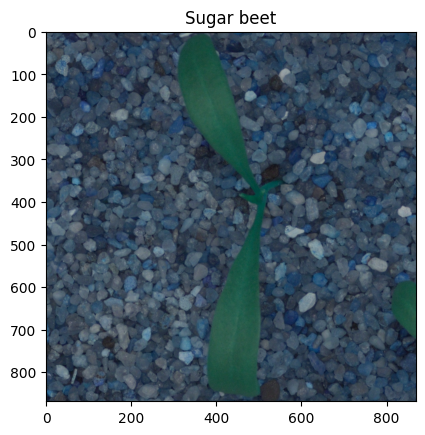

In [15]:
plot_single_image(images_df, 3000)

In [16]:
# let's go ahead and plat a bunch of our images together,
# so we get a better feeling of how our images look like

def plot_for_class(df, label):
    # function plots 9 images
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[ df["target"] == label ]
            tmp.reset_index(drop=True, inplace=True)
            im = cv2.imread(tmp.loc[n, 'image'])
            axs[i, j].imshow(im)
            n += 1

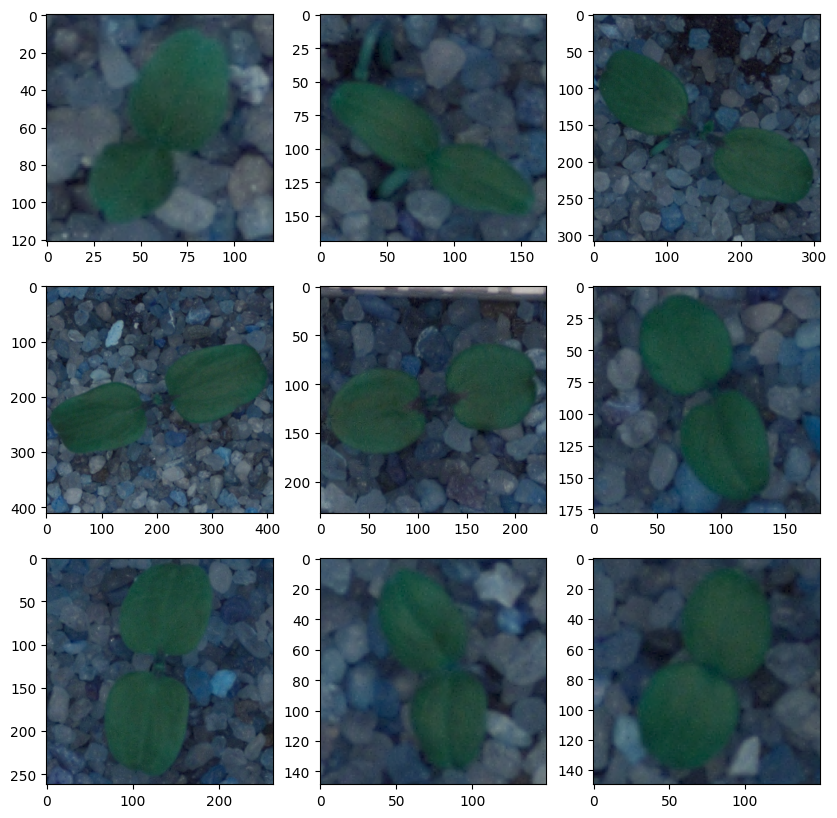

In [17]:
plot_for_class(images_df, 'Cleavers')

# 4  Separate train and test

In [19]:
# train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    images_df['image'], images_df['target'],
    test_size=0.2, random_state=101)

print(X_train.shape)
print(X_test.shape)

(4431,)
(1108,)


In [20]:
# the indeces of the training data are mixed
# this will cause problems later

X_train.head()

1922    /home/roberto/Documents/deployment_of_ML_prese...
4164    /home/roberto/Documents/deployment_of_ML_prese...
2952    /home/roberto/Documents/deployment_of_ML_prese...
287     /home/roberto/Documents/deployment_of_ML_prese...
4971    /home/roberto/Documents/deployment_of_ML_prese...
Name: image, dtype: object

In [21]:
# reset index, because later we iterate over row number

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_train.head()

0    /home/roberto/Documents/deployment_of_ML_prese...
1    /home/roberto/Documents/deployment_of_ML_prese...
2    /home/roberto/Documents/deployment_of_ML_prese...
3    /home/roberto/Documents/deployment_of_ML_prese...
4    /home/roberto/Documents/deployment_of_ML_prese...
Name: image, dtype: object

In [22]:
# reset index in target as well

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [23]:
# percentage of images within each class

y_train.value_counts() / len(y_train)

target
Loose Silky-bent             0.141503
Common Chickweed             0.125705
Scentless Mayweed            0.107425
Small-flowered Cranesbill    0.105168
Fat Hen                      0.097495
Sugar beet                   0.084405
Charlock                     0.082826
Cleavers                     0.060032
Black-grass                  0.055292
Shepherds Purse              0.049199
Maize                        0.046039
Common wheat                 0.044911
Name: count, dtype: float64

In [24]:
# should be the same in the test set

y_test.value_counts() / len(y_test)

target
Common Chickweed             0.140794
Loose Silky-bent             0.121841
Scentless Mayweed            0.118231
Small-flowered Cranesbill    0.099278
Fat Hen                      0.095668
Sugar beet                   0.080325
Charlock                     0.076715
Cleavers                     0.062274
Black-grass                  0.057762
Shepherds Purse              0.050542
Common wheat                 0.048736
Maize                        0.047834
Name: count, dtype: float64

In [25]:
# Let's preare the target
# it is a multiclass classification, so we need to make
# one hot encoding of the target

encoder = LabelEncoder()
encoder.fit(y_train)

train_y = np_utils.to_categorical(encoder.transform(y_train))
test_y = np_utils.to_categorical(encoder.transform(y_test))

train_y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [34]:
# the images in our folders, are all different sizes
# for neural networks however, we need images in the same size
# the iamges will all be resized to this size:

# IMAGE_SIZE = 150
IMAGE_SIZE = 50

In [35]:
def im_resize(df, n):
    im = cv2.imread(df[n])
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    return im

In [36]:
tmp = im_resize(X_train, 7)
tmp.shape

(50, 50, 3)

In [37]:
# the shape of the datasets needs to be (n1, n2, n3, n4)
# where n1 is the number of obervations
# n2 and n3 are image width and length
# and n4 indicates that it is a color image, so 3 planes per image

def create_dataset(df, image_size):
    # functions creates dataset as required for cnn
    tmp = np.zeros((len(df), image_size, image_size, 3), dtype='float32')

    for n in range(0, len(df)):
        im = im_resize(df, n)
        tmp[n] = im

    print(f'Datasets Images shape: {tmp.shape} size: {tmp.size}')
    return tmp

In [38]:
x_train = create_dataset(X_train, IMAGE_SIZE)

Datasets Images shape: (4431, 50, 50, 3) size: 33232500


In [39]:
x_test = create_dataset(X_test, IMAGE_SIZE)

Datasets Images shape: (1108, 50, 50, 3) size: 8310000


In [32]:
# number of different classes

len(y_train.unique())

12

In [40]:
# this is out CNN

kernel_size = (3, 3)
pool_size = (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation='relu',
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
#model.add(Conv2D(first_filters, kernel_size, activation='relu'))
#model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation='relu'))
#model.add(Conv2D(second_filters, kernel_size, activation='relu'))
#model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation='relu'))
#model.add(Conv2D(third_filters, kernel_size, activation='relu'))
#model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation = "softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 11, 11, 64)       

In [46]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

In [42]:
batch_size = 10
epochs = 3

In [48]:
x_train.shape

(4431, 50, 50, 3)

In [49]:
train_y.shape

(4431, 12)

In [47]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=1, verbose=1, mode='max', min_lr=0.00001)
callbacks_list = [checkpoint, reduce_lr]
history = model.fit(x=x_train, y=train_y,
                    batch_size=batch_size,
                    validation_split=10,
                    epochs=epochs,
                    verbose=2,
                    callbacks=callbacks_list)


Epoch 1/3


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plt(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

In [ ]:
# make a prediction

predictions = model.predict_classes(x_test, verbose=1)

In [ ]:
# inspect predictions
predictions

In [ ]:
# transform target
encoder.transform(y_test)

In [ ]:
cnf_matrix = confusion_matrix(encoder.transform(y_test), predictions)

In [43]:
# create a dict to map back the numbers onto the classes

tmp = pd.concat([y_test, pd.Series(encoder.transform(y_test))], axis=1)
tmp.colums = ['class_name', 'class_number']
tmp.drop_duplicates(inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp = pd.Series(tmp.class_name.values, index=tmp.class_number).to_dict()
tmp

AttributeError: 'DataFrame' object has no attribute 'class_name'

In [ ]:
# these we will display in the below matrix
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

In [44]:
import seaborn as sns

fix, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
# fig.savefig('Confusion_matrix.png', dpi=300)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(encoder.transform(y_test), predictions, normalize=True, sample_weight=None)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(encoder.transform(y_test), predictions))